# Understanding the Data

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

Import the necessary modules here

In [2]:
import numpy as np
import uproot as ur
import awkward as ak

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "5" # set to an available GPU
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

from PionReconstruction.util.Generators import *

data_path = '/fast_scratch_1/atlas_images/v01-45/'
cell_geo_path = data_path + 'cell_geo.root'
out_path = '/fast_scratch_1/jlerner/data/' # set your own output path for storing processed files

## Working with Uproot

Load in an event tree

In [3]:
pi0file = data_path + f'pi0/user.angerami.24559740.OutputStream._000011.root'
pipmfile = data_path + f'pipm/user.angerami.24559744.OutputStream._000011.root'
file = ur.open(pipmfile)
tree = file['EventTree']

Uncomment the cell below to see a list of observable quantities

In [4]:
#tree.keys()

Plot a few histograms of the cell energies and compare the normalization methods

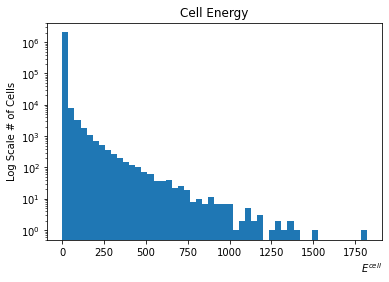

In [5]:
cell_E = ak.flatten(tree['cluster_cell_E'].array(), axis=None).to_numpy()
plt.xlabel(r'$E^{cell}$', loc='right')
plt.ylabel(r'Log Scale # of Cells')
plt.title('Cell Energy')
plt.hist(cell_E, 50, log=True)
plt.show()

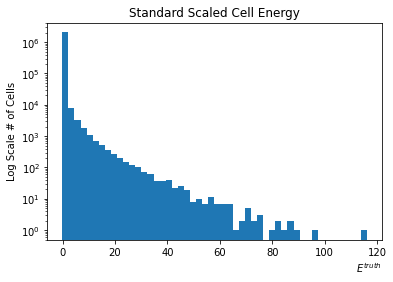

In [6]:
scaler = StandardScaler()
cell_E_std = scaler.fit_transform(cell_E.reshape(-1, 1))

plt.hist(cell_E_std, 50, log=True)
plt.xlabel(r'$E^{truth}$', loc='right')
plt.ylabel(r'Log Scale # of Cells')
plt.title('Standard Scaled Cell Energy')
plt.show()

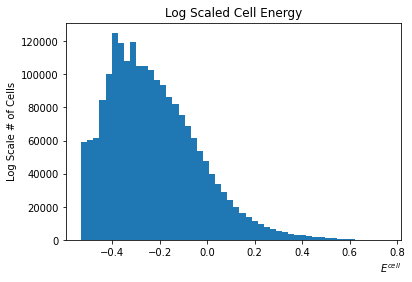

In [7]:
cell_E_log = np.nan_to_num(np.log(cell_E)/10, neginf=0.0)
cell_E_log = cell_E_log[cell_E_log != 0.0]
plt.hist(cell_E_log, 50)
plt.xlabel(r'$E^{cell}$', loc='right')
plt.ylabel(r'Log Scale # of Cells')
plt.title('Log Scaled Cell Energy')
plt.show()

A log function is the most effective normalization method

## Working with Generators

Make a new generator with a log normalizer and confirm the same distribution as before

In [8]:
generator = garnetDataGenerator(([[pi0file, 1]], [[pipmfile, 0]]),
                                cell_geo_path,
                                batch_size=20000,
                                normalizer=('log', None),
                                name='example',
                                vmax=128,
                                labeled=True,
                                preprocess=True,
                                output_dir=out_path + 'test/',
                                data_format='xne')


Loading Geo Dictionary...
	Starting on cell_geo_sampling
	Starting on cell_geo_eta
	Starting on cell_geo_phi
Finished loading Geo Dictionary

Preprocessing and saving data to /fast_scratch_1/jlerner/data/test/


In [9]:
x, y = next(generator.generator())

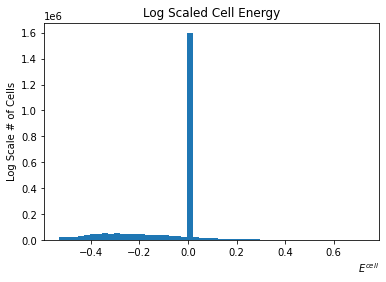

In [10]:
cell_E_log_p = ak.flatten(x[0][:, :, -1], axis=None)
plt.hist(cell_E_log_p, 50)
plt.xlabel(r'$E^{cell}$', loc='right')
plt.ylabel(r'Log Scale # of Cells')
plt.title('Log Scaled Cell Energy')
plt.show()

Where did all these 'log(E) = 0' cells come from? \
This is a result of padding every cluster to Vmax. \
See the 'Clipping and Padding' section of the \
`preprocessor` method in `Generators.py`.

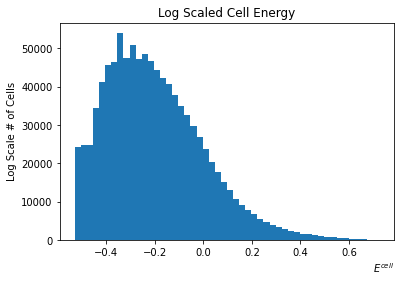

In [11]:
cell_E_log_p = cell_E_log_p[cell_E_log_p != 0.0]
plt.hist(cell_E_log_p, 50)
plt.xlabel(r'$E^{cell}$', loc='right')
plt.ylabel(r'Log Scale # of Cells')
plt.title('Log Scaled Cell Energy')
plt.show()

Cutting out the zero cells restores the distribution we expect to see. \
How can this be replicated in the training process? \
Ideally, the vertex mask should take care of this. \
Check out `Layers.py` and notice where vertex mask is utilized.